# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
import matplotlib.pyplot as plt

from core.network import FCN, Sin
from core.analytical import oscillator
import utils.plot

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

phi= -0.0
A= 0.5
tensor(1.)
torch.Size([500, 1]) torch.Size([500, 1])
tensor([0.]) tensor([1.])
torch.Size([2, 1]) torch.Size([2, 1])


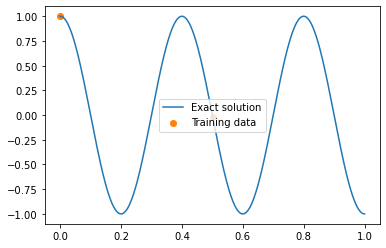

In [13]:
d, w0 = 0, 5*np.pi

# Initial Conditions determine a unique solution
tic = 0.0 # t0
xic = 1.0 # x(t0)
vic = 0.0 # x'(t0)


# get the analytical solution over the full domain
t_anal = torch.linspace(0,1,500).view(-1,1)


x_anal = oscillator(d, w0, t_anal, tic=tic, xic=xic, vic=vic).view(-1,1)
print(torch.max(torch.abs(x_anal)))
print(t_anal.shape, x_anal.shape)
print(t_anal[0], x_anal[0])

# slice out a small number of points from the LHS of the domain
# x_data = x[0:200:200]
# y_data = y[0:200:200]
t_data = t_anal[0:251:250]
x_data = x_anal[0:251:250]
print(t_data.shape, x_data.shape)


t0 = torch.Tensor([tic]).requires_grad_(True)
x0 = torch.Tensor([xic]).requires_grad_(True)
v0 = torch.Tensor([vic]).requires_grad_(True)
 

plt.figure()
plt.plot(t_anal, x_anal, label="Exact solution")
plt.scatter(t_data, x_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## PINN With IC

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

This time we use the first derivative at t=0 instead of the second point

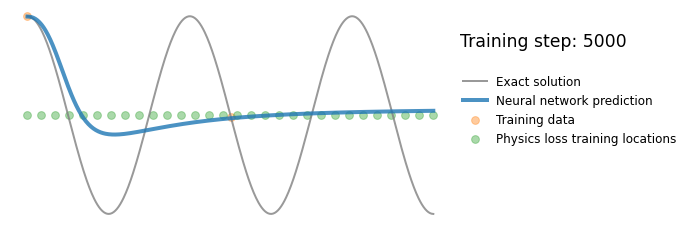

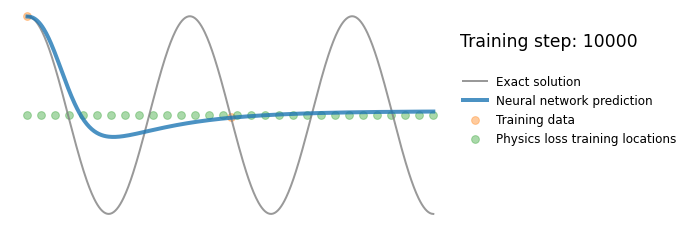

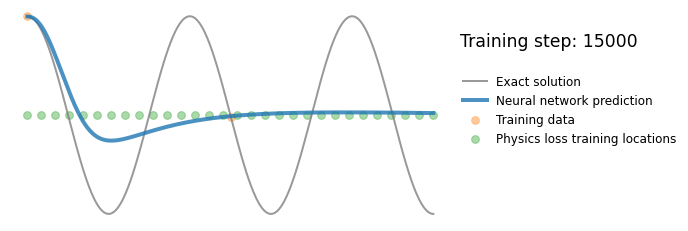

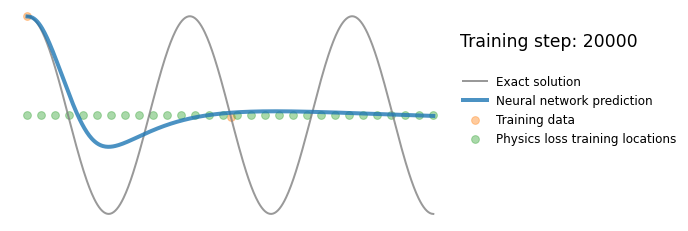

In [17]:
t_physics = torch.linspace(0,1.0,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

weight_interior = 1e-6

torch.manual_seed(125)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(20000):
    optimizer.zero_grad()
    
    # compute the "IC loss"
    x0_model = model(t0)
    dx0_model  = torch.autograd.grad(x0_model, t0, torch.ones_like(x0_model), create_graph=True)[0]# computes dy/dx
    lossic1 = torch.mean((x0_model-x0)**2)# use mean squared error
    lossic2 = torch.mean((dx0_model-v0)**2)# use mean squared error
    
    # compute the "domain interior loss"
    x_model = model(t_physics)
    dx_model  = torch.autograd.grad(x_model, t_physics, torch.ones_like(x_model), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx_model,  t_physics, torch.ones_like(dx_model),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx_model + k*x_model# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = weight_interior*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = lossic1 + lossic2 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 200 == 0: 
        
        x_pred = model(t_anal).detach()
        tp = t_physics.detach()
        
        fig = utils.plot.plot_result(t_anal,x_anal,t_data.detach(),x_data.detach(),x_pred,tp, i)
        
        file = "plots/pinn_%.8i.png"%(i+1)
        fig.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 5000 == 0: plt.show()
        else: plt.close("all")
            
utils.plot.save_gif_PIL("pinn.gif", files, fps=20, loop=0)